In [1]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))
getwd()

[1] "/mnt/hdd/develop/kaggle/R_sources/house_prices"

In [4]:
source('main.R')
house_prices$helpers$import_libs()

combined_dataset <-
    # load data
    house_prices$helpers$load_data() %>%
    #select(-one_of(house_prices$attributes_selection$discared_cat_vars)) %>%
    #select(-one_of(house_prices$attributes_selection$discared_num_vars)) %>%
    # remove outliers
    (house_prices$outliers$remove_outliers) %>%
    # fix NA values
    (house_prices$missing$categ$replace_with_most_common) %>%
    (house_prices$missing$categ$fix_valid) %>%
    (house_prices$missing$numeric$replace_with_zero) %>%
    mutate(
        price_log = log(SalePrice)
    ) %>%
    select(-SalePrice, -Id)

#####################
# transform numeric #
#####################

transformation_config <- house_prices$trans$numeric$get_transformation_config(combined_dataset)

transformation_config

combined_dataset <-
    house_prices$trans$numeric$apply_transform(combined_dataset, transformation_config)

#########################
# transform categorical #
#########################

combined_dataset <-
    house_prices$trans$categ$rating_transform(combined_dataset, price_log)

training_dataset <- combined_dataset %>% filter(dataSource == 'train') %>% select(-dataSource)

# %>%
#     # transform numeric
#     house_prices$trans$numeric$apply_transform(debug=TRUE) %>%
#     # transform categorical
#     house_prices$trans$categ$rating_transform(price_log)

combined_dataset %>% head

var,predictor,score
BsmtUnfSF,sqrt,79.97603
GrLivArea,log,91.15794
LotArea,log,73.38993
TotRmsAbvGrd,log,30.68502
X1stFlrSF,log,90.77166


Alley,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,⋯,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,dataSource,price_log
2.531822,2.564039,2.540871,2.320042,3.262019,2.553429,3.066343,2.57887,2.547619,2.50277,⋯,61,0,0,0,0,0,2,2008,train,12.24769
2.531822,2.564039,2.540871,3.295455,2.231818,2.553429,3.066343,2.57887,1.987500,2.50277,⋯,0,0,0,0,0,0,5,2007,train,12.10901
2.531822,2.564039,2.540871,2.675439,3.262019,2.553429,3.066343,2.57887,2.547619,2.50277,⋯,42,0,0,0,0,0,9,2008,train,12.31717
2.531822,2.564039,3.046154,2.320042,2.231818,2.553429,1.847458,2.57887,2.547619,2.50277,⋯,35,272,0,0,0,0,2,2006,train,11.84940
2.531822,2.564039,2.540871,2.900452,3.262019,2.553429,3.066343,2.57887,2.547619,2.50277,⋯,84,0,0,0,0,0,12,2008,train,12.42922
2.531822,2.564039,2.540871,2.320042,3.262019,2.553429,3.066343,2.57887,2.547619,2.50277,⋯,30,0,320,0,0,700,10,2009,train,11.87060


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.7641906,0.7638664,0.194236,2357.618,0,3,321.8864,-635.7728,-614.6335,54.89371,1455


term,estimate,std.error,statistic,p.value
(Intercept),7.6588878,0.126036731,60.76711,0.000000e+00
GrLivArea,0.4565688,0.019430309,23.49777,9.051174e-104
OverallQual,0.1718658,0.004660648,36.87594,9.636469e-211


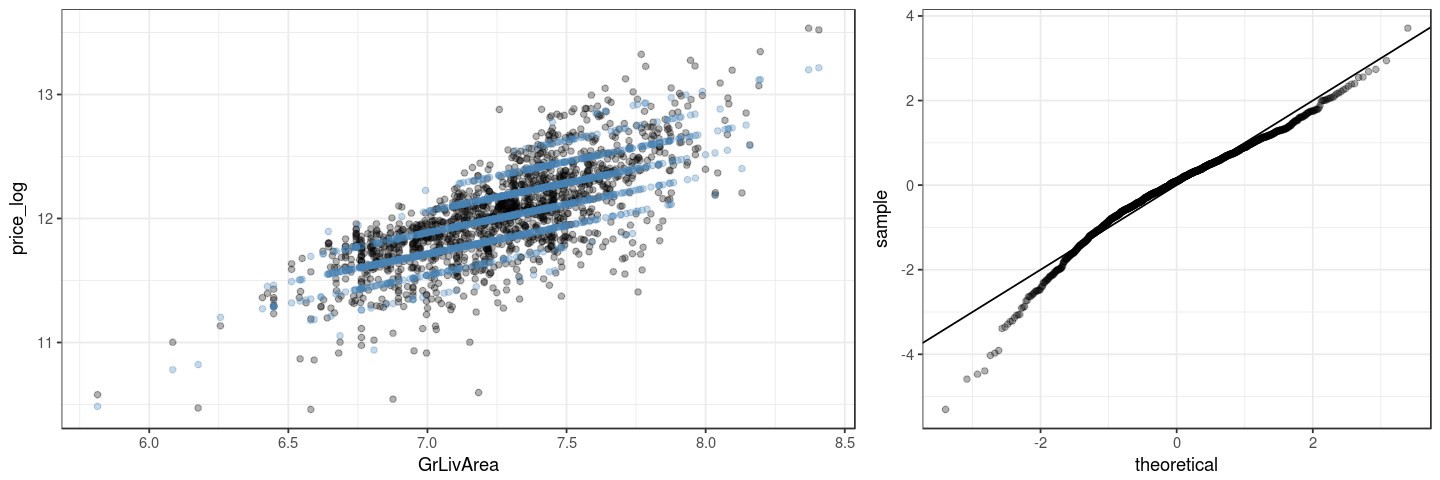

In [50]:
options(repr.plot.width = 12, repr.plot.height = 4)


mod <- lm(price_log ~ GrLivArea + OverallQual, data=training_dataset)

mod %>% glance
mod %>% tidy

plt_scatter <-
    mod %>%
    augment %>%
    ggplot() +
    geom_point(aes(x=GrLivArea, y=price_log), alpha=0.3) +
    geom_point(aes(x=GrLivArea, y=.fitted), alpha=0.3, color='steelblue') +
    theme_bw()

plt_qq <-
    mod %>%
    augment %>%
    select(resid=.resid) %>%
    mutate(
        resid_normed = (resid - mean(resid)) / sd(resid)
    ) %>%
    ggplot() +
    geom_qq(aes(sample=resid_normed), alpha=0.3) +
    geom_abline(slope=1, color="black") +
    theme_bw()

grid.arrange(
    plt_scatter, plt_qq, 
    layout_matrix=rbind(c(1, 2)), 
    widths=c(60, 40)
)

In [38]:
iterate <- function(base_formula_str, dataset) {
    
    base_formula <- as.formula(base_formula_str)
    target <- all.vars(f)[1]
    all_predictors <- setdiff(colnames(dataset), target)
    base_predictors <- labels(terms(base_formula))
    remaining_predictors <- setdiff(all_predictors, base_predictors)
    
    data_frame(
        base_formula = base_formula_str,
        var_name = remaining_predictors
    ) %>%
    mutate(
        formula = paste0(base_formula, ' + ', var_name),
        base_r2 = summary(lm(as.formula(base_formula), data=training_dataset))$r.squared
    ) %>%
    mutate(    
        model = map(formula, ~lm(as.formula(.), data=dataset)),

        r2 = map_dbl(model, function (mod) {
            summary(mod)$r.squared
        }),

        r2_gain = 100 * (r2 - base_r2) / base_r2,

        max_corr = map2_dbl(base_formula, var_name, function(base_formula, var_name) {
            base_predictors <- labels(terms(as.formula(base_formula)))
            max(abs(cor(dataset[base_predictors], dataset[var_name])))
        })        
    ) %>%
    select(-model, -base_formula, -var_name) %>%
    filter(r2_gain > 1, max_corr < 0.5) %>%
    mutate(
        score = r2_gain / max_corr
    ) %>%
    arrange(desc(score))
}

In [39]:
iterate('price_log ~ GrLivArea + OverallQual', training_dataset)

formula,base_r2,r2,r2_gain,max_corr,score
price_log ~ GrLivArea + OverallQual + BsmtFullBath,0.7641906,0.7942177,3.929280,0.1040203,37.774173
price_log ~ GrLivArea + OverallQual + BsmtFinSF1,0.7641906,0.8112984,6.164409,0.2224668,27.709340
price_log ~ GrLivArea + OverallQual + MSZoning,0.7641906,0.7976550,4.379065,0.2709276,16.163228
price_log ~ GrLivArea + OverallQual + LotArea,0.7641906,0.7950914,4.043610,0.3744884,10.797693
price_log ~ GrLivArea + OverallQual + CentralAir,0.7641906,0.7858417,2.833218,0.2725223,10.396279
price_log ~ GrLivArea + OverallQual + PavedDrive,0.7641906,0.7817124,2.292868,0.2299452,9.971364
price_log ~ GrLivArea + OverallQual + BsmtExposure,0.7641906,0.7874410,3.042489,0.3178275,9.572768
price_log ~ GrLivArea + OverallQual + LotShape,0.7641906,0.7760579,1.552934,0.1980686,7.840387
price_log ~ GrLivArea + OverallQual + GarageQual,0.7641906,0.7804420,2.126615,0.2946396,7.217683
price_log ~ GrLivArea + OverallQual + GarageType,0.7641906,0.7901193,3.392974,0.4950769,6.853427


In [40]:
iterate('price_log ~ GrLivArea + OverallQual + BsmtFinSF1', training_dataset)

formula,base_r2,r2,r2_gain,max_corr,score
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning,0.8112984,0.8362138,3.071050,0.2709276,11.335315
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + CentralAir,0.8112984,0.8262211,1.839357,0.2725223,6.749381
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + SaleCondition,0.8112984,0.8281102,2.072213,0.3230405,6.414715
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + LotArea,0.8112984,0.8301062,2.318238,0.3744884,6.190414
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + PavedDrive,0.8112984,0.8212354,1.224826,0.2299452,5.326598
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + GarageQual,0.8112984,0.8220150,1.320918,0.2946396,4.483164
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + GarageCond,0.8112984,0.8223195,1.358449,0.3071248,4.423118
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + SaleType,0.8112984,0.8231060,1.455391,0.3291060,4.422256
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + GarageType,0.8112984,0.8285213,2.122880,0.4950769,4.287980
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + HeatingQC,0.8112984,0.8255391,1.755302,0.4666565,3.761443


In [41]:
iterate('price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning', training_dataset)

formula,base_r2,r2,r2_gain,max_corr,score
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition,0.8362138,0.8494706,1.585338,0.3230405,4.907552
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + CentralAir,0.8362138,0.8450956,1.062150,0.2725223,3.897478
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleType,0.8362138,0.8449009,1.038871,0.3291060,3.156645
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + LotArea,0.8362138,0.8456007,1.122551,0.3744884,2.997559
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + BsmtExposure,0.8362138,0.8451276,1.065980,0.3760118,2.834966
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + Exterior1st,0.8362138,0.8456955,1.133887,0.4027935,2.815057
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + HeatingQC,0.8362138,0.8470447,1.295230,0.4666565,2.775552
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + Exterior2nd,0.8362138,0.8448030,1.027155,0.4044553,2.539601
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + GarageType,0.8362138,0.8450885,1.061296,0.4950769,2.143700


In [42]:
iterate('price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition', training_dataset)

formula,base_r2,r2,r2_gain,max_corr,score
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition + CentralAir,0.8494706,0.8582440,1.032806,0.2725223,3.789804
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition + LotArea,0.8494706,0.8586429,1.079771,0.3744884,2.883324


In [43]:
iterate('price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition + CentralAir', training_dataset)

formula,base_r2,r2,r2_gain,max_corr,score
price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition + CentralAir + LotArea,0.858244,0.868304,1.172163,0.3744884,3.130037


In [44]:
iterate('price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition + CentralAir + LotArea', training_dataset)

formula,base_r2,r2,r2_gain,max_corr,score


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.868304,0.8676682,0.1454062,1365.743,0,8,746.5491,-1475.098,-1427.535,30.65731,1450


term,estimate,std.error,statistic,p.value
(Intercept),6.452080438,1.088806e-01,59.258327,0.000000e+00
GrLivArea,0.409564238,1.563185e-02,26.200623,3.375340e-124
OverallQual,0.133421295,3.864214e-03,34.527406,3.691892e-191
BsmtFinSF1,0.000169822,9.286001e-06,18.287957,2.161311e-67
MSZoning,0.087209339,8.948344e-03,9.745864,8.804785e-22
SaleCondition,0.135200369,1.133618e-02,11.926452,2.389150e-31
CentralAir,0.134566297,1.304747e-02,10.313594,4.071741e-24
LotArea,0.089686568,8.521782e-03,10.524391,5.180426e-25


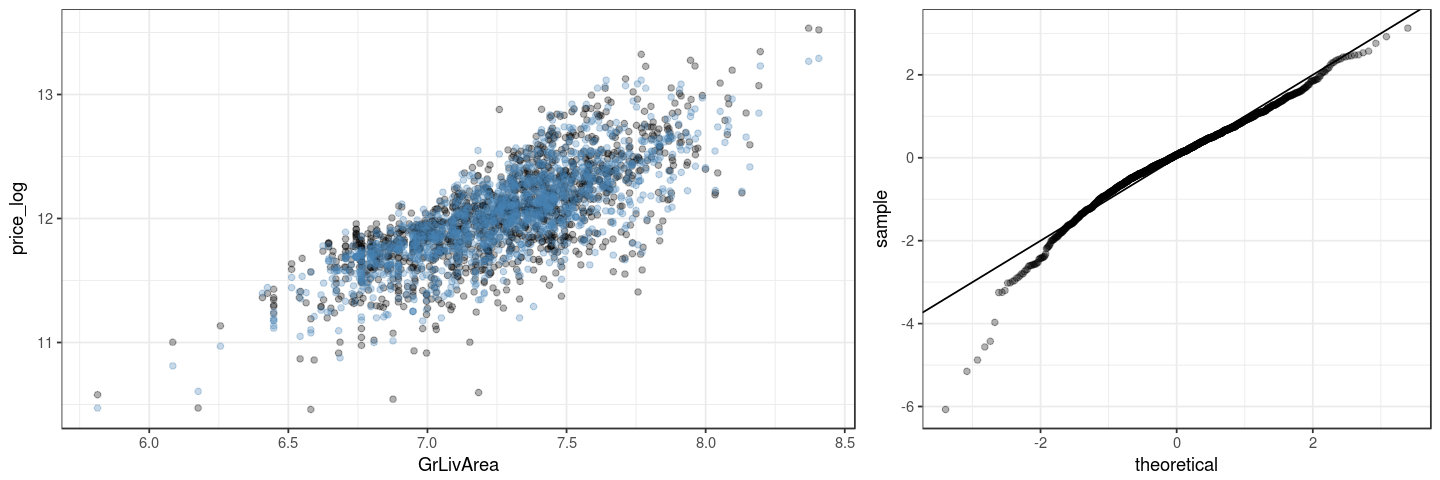

In [49]:
options(repr.plot.width = 12, repr.plot.height = 4)

mod <- lm(price_log ~ GrLivArea + OverallQual + BsmtFinSF1 + MSZoning + SaleCondition + CentralAir + LotArea, data=training_dataset)

mod %>% glance
mod %>% tidy

plt_scatter <-
    mod %>%
    augment %>%
    ggplot() +
    geom_point(aes(x=GrLivArea, y=price_log), alpha=0.3) +
    geom_point(aes(x=GrLivArea, y=.fitted), alpha=0.3, color='steelblue') +
    theme_bw()

plt_qq <-
    mod %>%
    augment %>%
    select(resid=.resid) %>%
    mutate(
        resid_normed = (resid - mean(resid)) / sd(resid)
    ) %>%
    ggplot() +
    geom_qq(aes(sample=resid_normed), alpha=0.3) +
    geom_abline(slope=1, color="black") +
    theme_bw()

grid.arrange(
    plt_scatter, plt_qq, 
    layout_matrix=rbind(c(1, 2)), 
    widths=c(60, 40)
)